In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

On ouvre le fichier contenant les informations radiomiques globales

In [2]:
data_path_global = 'data/liver_tumors.csv'
df = pd.read_csv(data_path_global)
df

,Unnamed: 0,classe_name,diagnostics_Configuration_EnabledImageTypes,diagnostics_Configuration_Settings,diagnostics_Image-interpolated_Maximum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Size,diagnostics_Image-interpolated_Spacing,diagnostics_Image-original_Dimensionality,...,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,patient_num,temps_inj
0,0,CCK,NaN,NaN,494.0,185.910073,0.0,33.0,2.0,3D,...,52.153619,67.052218,27028.666667,41.499767,0.585506,7438.791736,0.275219,27272.0,10,ART
1,0,CCK,NaN,NaN,461.0,205.482534,0.0,33.0,2.0,3D,...,52.153619,67.052218,27028.666667,41.499767,0.585506,7438.791736,0.275219,27272.0,10,PORT
2,0,CCK,NaN,NaN,387.0,197.526632,0.0,33.0,2.0,3D,...,52.153619,66.211781,26860.666667,41.595464,0.597962,7253.621621,0.270046,27096.0,10,TARD
3,0,CCK,NaN,NaN,422.0,205.327044,0.0,33.0,2.0,3D,...,52.153619,66.211781,26860.666667,41.595464,0.597962,7253.621621,0.270046,27096.0,10,VEIN
4,0,CCK,NaN,NaN,2503.0,751.834320,59.0,28.0,2.0,3D,...,35.383612,40.249224,14893.000000,28.140143,0.719555,4068.253028,0.273165,15056.0,11,ART
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,0,Mixtes,NaN,NaN,165.0,121.765046,20.0,18.0,2.0,3D,...,12.649111,14.000000,436.333333,9.242349,0.825430,337.041193,0.772440,480.0,8,VEIN
530,0,Mixtes,NaN,NaN,881.0,196.474776,0.0,36.0,2.0,3D,...,56.035703,62.385896,51861.000000,42.498561,0.695980,9663.061894,0.186326,52144.0,9,ART
531,0,Mixtes,NaN,NaN,881.0,205.028185,0.0,35.0,2.0,3D,...,54.037024,62.513998,46217.666667,42.501632,0.690098,9024.968050,0.195271,46456.0,9,PORT
532,0,Mixtes,NaN,NaN,801.0,190.429739,0.0,34.0,2.0,3D,...,56.639209,61.188234,51048.000000,44.286876,0.714458,9314.502411,0.182466,51280.0,9,TARD


On retire les colonnes non numériques

In [3]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.dropna(axis=1, inplace = True)

for col in df:
    if 'diagnostics_' in col:
        df.drop([col], axis = 1, inplace = True)

On retire la phase avec le moins de patients

In [4]:
n_ART = len(df[df['temps_inj']=='ART'])
n_PORT = len(df[df['temps_inj']=='PORT'])
n_VEIN = len(df[df['temps_inj']=='VEIN'])
n_TARD = len(df[df['temps_inj']=='TARD'])

df_CHC = df.loc[df['classe_name']=='CHC']
df_CCK = df.loc[df['classe_name']=='CCK']
df_Mixtes = df.loc[df['classe_name']=='Mixtes']

On prépare finalement les données pour entrainer un modèle, séparément pour les différents labels

In [5]:
def prep_data(dataframe, number_patient_max = 223):
    new_data = []
    for n_patient in range(number_patient_max):
        # On regrde les 4 phases de chaque patient
        a = dataframe.loc[dataframe['patient_num']==n_patient]
        new_row = {}
        phases = []

        #On regarde les phases dispoq chez le patient
        for index0, row0 in a.iterrows():
            phases.append(row0['temps_inj'])

        if ('ART' in phases) and ('PORT' in phases) and ('TARD' in phases):
            #On opère seulement si il a les 3 phases désirées

            for index, row in a.iterrows():
                for label, content in df.items():
                    #On ajoute les données de chaque phase à la ligne du patient
                    b = row['temps_inj']
                    if b != 'VEIN':
                        # On drop la phase veineuse
                        new_row[f'{label}_{b}'] = row[label]

            new_data.append(new_row)

    df_concat = pd.DataFrame(new_data)
    df_concat.dropna(axis=0, inplace = True)
    for col in df_concat:
        if 'temps_inj' in col:
            df_concat.drop([col], axis = 1, inplace = True)
        if 'patient_num' in col:
            df_concat.drop([col], axis = 1, inplace = True)
    return df_concat

In [7]:
df_concat_CHC = prep_data(df_CHC)
df_concat_CCK = prep_data(df_CCK)
df_concat_Mixtes = prep_data(df_Mixtes)

df_concat_CHC

,classe_name_ART,original_firstorder_10Percentile_ART,original_firstorder_90Percentile_ART,original_firstorder_Energy_ART,original_firstorder_Entropy_ART,original_firstorder_InterquartileRange_ART,original_firstorder_Kurtosis_ART,original_firstorder_Maximum_ART,original_firstorder_Mean_ART,original_firstorder_MeanAbsoluteDeviation_ART,...,original_shape_Maximum2DDiameterColumn_TARD,original_shape_Maximum2DDiameterRow_TARD,original_shape_Maximum2DDiameterSlice_TARD,original_shape_Maximum3DDiameter_TARD,original_shape_MeshVolume_TARD,original_shape_MinorAxisLength_TARD,original_shape_Sphericity_TARD,original_shape_SurfaceArea_TARD,original_shape_SurfaceVolumeRatio_TARD,original_shape_VoxelVolume_TARD
0,CHC,158.5,260.5,6.089318e+06,2.638516,54.25,2.288585,305.0,208.250000,31.121324,...,16.000000,19.697716,18.439089,20.099751,1.575000e+03,12.979212,0.831231,787.558628,0.500037,1640.0
1,CHC,75.0,257.0,4.101481e+08,3.402535,105.00,2.324426,415.0,170.009705,55.847616,...,65.604878,64.621978,63.529521,70.199715,9.947500e+04,51.797922,0.804533,12904.746342,0.129729,99744.0
2,CHC,59.0,85.0,9.894201e+07,1.143037,13.00,4.026323,116.0,72.180410,8.199455,...,69.339743,78.230429,76.576759,80.870266,1.480783e+05,59.017449,0.805658,16800.721242,0.113458,148368.0
3,CHC,61.0,92.0,1.447900e+07,1.190851,17.00,2.843000,111.0,75.037480,9.704294,...,43.908997,46.043458,46.647615,51.029403,1.998433e+04,36.528676,0.730238,4876.927298,0.244038,20152.0
4,CHC,79.0,360.0,1.459759e+10,4.029531,144.00,2.726163,823.0,225.413377,83.530381,...,199.849944,202.158354,176.510623,206.029124,1.917925e+06,152.650307,0.673712,110806.219247,0.057774,1918792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,CHC,227.0,315.4,9.356924e+06,2.443151,44.00,2.697852,350.0,267.271318,26.030888,...,18.439089,10.770330,18.439089,18.867962,5.930000e+02,9.197157,0.732276,466.136111,0.786064,648.0
66,CHC,94.0,131.0,9.856225e+06,1.365369,20.00,3.010348,166.0,111.795103,11.469517,...,31.048349,24.413111,30.066593,32.619013,7.253000e+03,20.915715,0.810228,2236.429688,0.308345,7360.0
67,CHC,92.6,132.0,2.249035e+06,1.517937,25.00,1.912370,141.0,111.734463,12.797408,...,15.620499,15.620499,16.124515,17.549929,1.477333e+03,13.130094,0.880235,712.641598,0.482384,1536.0
68,CHC,141.0,168.0,2.313777e+07,1.016007,13.75,4.317171,181.0,155.009395,8.472468,...,19.697716,25.298221,24.331050,26.000000,3.654667e+03,17.444091,0.826473,1388.312634,0.379874,3736.0


In [8]:
df_concat_CCK

,classe_name_ART,original_firstorder_10Percentile_ART,original_firstorder_90Percentile_ART,original_firstorder_Energy_ART,original_firstorder_Entropy_ART,original_firstorder_InterquartileRange_ART,original_firstorder_Kurtosis_ART,original_firstorder_Maximum_ART,original_firstorder_Mean_ART,original_firstorder_MeanAbsoluteDeviation_ART,...,original_shape_Maximum2DDiameterColumn_TARD,original_shape_Maximum2DDiameterRow_TARD,original_shape_Maximum2DDiameterSlice_TARD,original_shape_Maximum3DDiameter_TARD,original_shape_MeshVolume_TARD,original_shape_MinorAxisLength_TARD,original_shape_Sphericity_TARD,original_shape_SurfaceArea_TARD,original_shape_SurfaceVolumeRatio_TARD,original_shape_VoxelVolume_TARD
0,CCK,208.0,781.0,1.124741e+10,5.030686,304.00,4.270294,1660.0,446.885992,183.919090,...,101.607086,121.276543,120.880106,124.498996,378073.333333,77.388643,0.580690,43543.514315,0.115172,378632.0
1,CCK,404.5,573.5,2.473412e+08,3.382653,89.00,2.931495,724.0,499.119877,52.454229,...,31.304952,34.409301,32.984845,34.641016,8917.666667,23.182631,0.729512,2850.706982,0.319670,9056.0
2,CCK,998.7,1446.4,3.270323e+08,4.709174,244.00,2.708644,1747.0,1235.490476,142.080771,...,30.066593,19.697716,30.463092,32.372828,3036.000000,16.967494,0.737635,1374.601949,0.452767,3128.0
3,CCK,277.0,434.0,2.408947e+09,3.384328,79.00,3.754457,629.0,352.496539,49.214684,...,99.859902,97.754795,96.332757,112.605506,179092.000000,79.589469,0.620161,24775.955091,0.138342,179544.0
4,CCK,57.0,140.0,1.150443e+08,2.321597,45.00,4.289346,297.0,90.959603,27.195391,...,120.830460,71.217975,99.297533,127.828009,97033.000000,44.517305,0.462481,22080.187822,0.227553,97632.0
5,CCK,75.0,115.0,9.661774e+06,1.560550,20.00,3.544537,146.0,94.357414,12.843152,...,33.105891,26.076810,30.463092,35.213634,6641.000000,21.099557,0.775232,2203.982018,0.331875,6752.0
6,CCK,88.0,133.0,2.413912e+07,1.634920,24.00,2.934647,181.0,110.876891,13.783140,...,38.209946,34.058773,37.363083,39.496835,14329.666667,27.473781,0.736430,3874.154336,0.270359,14504.0
7,CCK,190.0,400.0,6.009232e+09,3.707574,113.00,4.158247,929.0,283.981700,66.762307,...,134.417261,128.887548,134.833230,155.563492,523429.333333,94.452297,0.495193,63428.035595,0.121178,524592.0
8,CCK,211.0,367.0,3.015106e+08,3.268826,99.00,2.320545,433.0,291.173951,51.230947,...,50.596443,62.481997,52.153619,66.211781,26860.666667,41.595464,0.597962,7253.621621,0.270046,27096.0
9,CCK,260.1,894.0,7.323840e+08,5.230583,408.75,2.690676,1591.0,571.664718,209.770220,...,38.418745,38.832976,35.383612,40.249224,14893.000000,28.140143,0.719555,4068.253028,0.273165,15056.0


In [9]:
df_concat_Mixtes

,classe_name_ART,original_firstorder_10Percentile_ART,original_firstorder_90Percentile_ART,original_firstorder_Energy_ART,original_firstorder_Entropy_ART,original_firstorder_InterquartileRange_ART,original_firstorder_Kurtosis_ART,original_firstorder_Maximum_ART,original_firstorder_Mean_ART,original_firstorder_MeanAbsoluteDeviation_ART,...,original_shape_Maximum2DDiameterColumn_TARD,original_shape_Maximum2DDiameterRow_TARD,original_shape_Maximum2DDiameterSlice_TARD,original_shape_Maximum3DDiameter_TARD,original_shape_MeshVolume_TARD,original_shape_MinorAxisLength_TARD,original_shape_Sphericity_TARD,original_shape_SurfaceArea_TARD,original_shape_SurfaceVolumeRatio_TARD,original_shape_VoxelVolume_TARD
0,Mixtes,117.0,209.0,7.676788e+07,2.492801,60.00,2.085669,257.0,162.595101,29.993017,...,41.231056,40.000000,36.715120,44.226689,2.204233e+04,30.306314,0.787622,4826.935258,0.218985,22208.0
1,Mixtes,125.0,297.0,1.400011e+08,3.286945,115.00,1.841024,371.0,213.507303,57.515386,...,40.496913,42.801869,39.849718,43.543082,2.175000e+04,33.205300,0.786534,4790.777768,0.220266,21912.0
2,Mixtes,256.0,378.0,5.898877e+07,3.024556,65.00,3.036212,448.0,317.089005,38.885593,...,22.360680,24.413111,21.540659,24.738634,3.364000e+03,18.098550,0.809503,1341.229366,0.398701,3448.0
3,Mixtes,118.0,153.0,1.298205e+08,1.394171,19.00,3.396244,202.0,135.696874,11.313374,...,55.027266,54.037024,54.918121,56.780278,4.410700e+04,42.718257,0.710338,8498.790860,0.192686,44344.0
4,Mixtes,76.0,193.0,1.454490e+09,2.823980,68.00,2.827900,325.0,127.788199,37.758018,...,124.867930,119.883277,105.678759,126.158630,5.493280e+05,90.023593,0.766231,42332.970729,0.077063,550152.0
5,Mixtes,125.0,186.0,4.575453e+06,2.028803,41.25,2.157157,205.0,157.450000,21.569444,...,17.204651,17.204651,15.620499,18.220867,1.559667e+03,13.593141,0.873651,744.447388,0.477312,1616.0
6,Mixtes,134.0,157.0,1.475746e+06,1.122335,13.00,3.182262,164.0,143.859155,7.474707,...,12.649111,10.770330,12.649111,14.000000,4.363333e+02,9.242349,0.825430,337.041193,0.772440,480.0
7,Mixtes,180.7,416.3,5.530363e+08,3.716371,115.00,3.639202,671.0,276.182111,73.399140,...,54.589376,59.059292,56.639209,61.188234,5.104800e+04,44.286876,0.714458,9314.502411,0.182466,51280.0
8,Mixtes,101.0,199.0,4.730910e+08,2.659215,52.00,3.793519,364.0,146.151361,31.119158,...,78.000000,84.023806,79.120162,85.182158,1.719367e+05,63.662563,0.779293,19187.978521,0.111599,172272.0
9,Mixtes,147.0,278.0,3.693517e+08,3.057281,70.00,2.767975,380.0,209.326182,40.435909,...,58.412327,57.306195,56.035703,63.686733,6.353800e+04,46.859196,0.750884,10254.947554,0.161399,63768.0


On s'occupe d'abord de classifier entre CHC et CCK, et on prendra en compte les mixtes ensuite

In [10]:
df_red =  pd.concat([df_concat_CHC, df_concat_CCK])
df_red.rename(columns = {'classe_name_ART': 'classe_name'}, inplace = True)
df_red.drop(['classe_name_PORT', 'classe_name_TARD'], inplace = True, axis = 1)
df_red

df_concat = pd.concat([df_concat_CHC, df_concat_CCK, df_concat_Mixtes])
df_concat.rename(columns = {'classe_name_ART': 'classe_name'}, inplace = True)

df_concat.drop(['classe_name_PORT', 'classe_name_TARD'], inplace = True, axis = 1)
df_concat

,classe_name,original_firstorder_10Percentile_ART,original_firstorder_90Percentile_ART,original_firstorder_Energy_ART,original_firstorder_Entropy_ART,original_firstorder_InterquartileRange_ART,original_firstorder_Kurtosis_ART,original_firstorder_Maximum_ART,original_firstorder_Mean_ART,original_firstorder_MeanAbsoluteDeviation_ART,...,original_shape_Maximum2DDiameterColumn_TARD,original_shape_Maximum2DDiameterRow_TARD,original_shape_Maximum2DDiameterSlice_TARD,original_shape_Maximum3DDiameter_TARD,original_shape_MeshVolume_TARD,original_shape_MinorAxisLength_TARD,original_shape_Sphericity_TARD,original_shape_SurfaceArea_TARD,original_shape_SurfaceVolumeRatio_TARD,original_shape_VoxelVolume_TARD
0,CHC,158.5,260.5,6.089318e+06,2.638516,54.25,2.288585,305.0,208.250000,31.121324,...,16.000000,19.697716,18.439089,20.099751,1.575000e+03,12.979212,0.831231,787.558628,0.500037,1640.0
1,CHC,75.0,257.0,4.101481e+08,3.402535,105.00,2.324426,415.0,170.009705,55.847616,...,65.604878,64.621978,63.529521,70.199715,9.947500e+04,51.797922,0.804533,12904.746342,0.129729,99744.0
2,CHC,59.0,85.0,9.894201e+07,1.143037,13.00,4.026323,116.0,72.180410,8.199455,...,69.339743,78.230429,76.576759,80.870266,1.480783e+05,59.017449,0.805658,16800.721242,0.113458,148368.0
3,CHC,61.0,92.0,1.447900e+07,1.190851,17.00,2.843000,111.0,75.037480,9.704294,...,43.908997,46.043458,46.647615,51.029403,1.998433e+04,36.528676,0.730238,4876.927298,0.244038,20152.0
4,CHC,79.0,360.0,1.459759e+10,4.029531,144.00,2.726163,823.0,225.413377,83.530381,...,199.849944,202.158354,176.510623,206.029124,1.917925e+06,152.650307,0.673712,110806.219247,0.057774,1918792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,Mixtes,1590.4,2552.4,6.475134e+09,5.801585,407.00,6.243191,3083.0,2153.524272,319.244966,...,31.240999,31.622777,30.594117,33.105891,8.238333e+03,24.531604,0.760848,2592.662065,0.314707,8360.0
24,Mixtes,61.0,100.0,2.420025e+07,1.421675,20.00,3.325873,136.0,78.469253,12.058169,...,51.613952,50.477718,42.801869,52.573758,3.313500e+04,37.295023,0.755233,6605.838202,0.199361,33344.0
25,Mixtes,227.0,385.0,1.876894e+09,3.394323,75.00,3.700555,573.0,305.715771,48.917455,...,124.338248,123.628476,76.550637,137.419067,1.531023e+05,62.377168,0.556616,24864.686251,0.162406,153848.0
26,Mixtes,40.0,102.0,8.092620e+06,1.962684,37.00,2.226598,143.0,72.761905,19.786986,...,35.440090,42.520583,37.576588,42.708313,1.359500e+04,28.746947,0.705982,3901.903692,0.287010,13768.0


## Analyse de la séparabilité des classes avec UMAP

In [ ]:
!pip install umap-learn

import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler

On commence d'abord avec les 3 classes

In [ ]:
reducer = umap.UMAP()
df_concat_val = df_concat.drop(['classe_name'], axis = 1).values
scaled_df_concat = StandardScaler().fit_transform(df_concat_val)
embedding = reducer.fit_transform(scaled_df_concat)
embedding.shape



In [ ]:
plt.scatter(embedding[:, 0],embedding[:, 1],c=[sns.color_palette()[x] for x in df_concat.classe_name.map({'CHC':0, 'CCK':1, 'Mixtes':2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24)

Puis seulement en considérant CHC et CCK

In [ ]:
df_red_val = df_red.drop(['classe_name'], axis = 1).values
scaled_df_red = StandardScaler().fit_transform(df_red_val)
embedding = reducer.fit_transform(scaled_df_red)
embedding.shape

In [ ]:
plt.scatter(embedding[:, 0],embedding[:, 1],c=[sns.color_palette()[x] for x in df_red.classe_name.map({'CHC':0, 'CCK':1, 'Mixtes':2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the reduced dataset (no Mixtes)', fontsize=24)

# Entrainement d'un classifieur XGB et évaluation des résultats

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [14]:
def plot_results(classifier, X_test, y_test):
    # preparing evaluation metric plots
    results = classifier.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    # xgboost 'mlogloss' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.ylabel('mlogloss')
    plt.title('GridSearchCV XGBoost mlogloss')
    plt.show()

    # xgboost 'merror' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    plt.ylabel('merror')
    plt.title('GridSearchCV XGBoost merror')
    plt.show()

    ## ---------- Model Classification Report ----------
    ## get predictions and create model quality report

    y_pred = classifier.predict(X_test)

    print('\n------------------ Confusion Matrix -----------------\n')
    print(confusion_matrix(y_test, y_pred))

    print('\n-------------------- Key Metrics --------------------')
    print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    print('\n--------------- Classification Report ---------------\n')
    print(classification_report(y_test, y_pred))
    print('---------------------- XGBoost ----------------------') 

def Cross_Val(model,X,y,X_test, y_test, n_fold = 20):
    score = []
    scaler = StandardScaler()
    for n in tqdm(range(n_fold)):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)
        clf = model.fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])
        y_pred = clf.predict(X_val)
        score.append(balanced_accuracy_score(y_pred, y_val))
    return np.mean(score), np.std(score)

D'abord sur les CHC/CCK

In [16]:

# train and test split --> stratified
X_red = df_red.drop('classe_name', axis=1).copy()
y_red = df_red['classe_name'].copy()

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, random_state=42, stratify=y_red)

y_red_train.replace('CHC', 0, inplace = True)
y_red_train.replace('CCK', 1, inplace = True)
#y_train.replace('Mixtes', 1, inplace = True)

y_red_test.replace('CHC', 0, inplace = True)
y_red_test.replace('CCK', 1, inplace = True)
#y_test.replace('Mixtes', 1, inplace = True)

In [17]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=2,
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.05,
                            max_depth=10,
                            #reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_red_train,
            y_red_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_red_train, y_red_train), (X_red_test, y_red_test)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

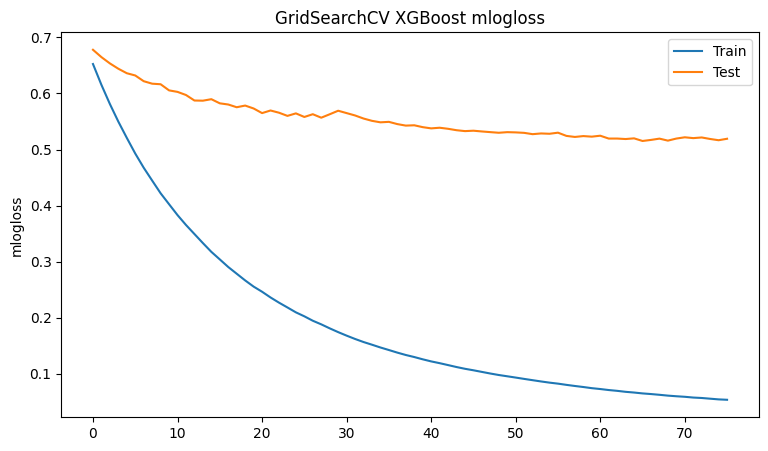

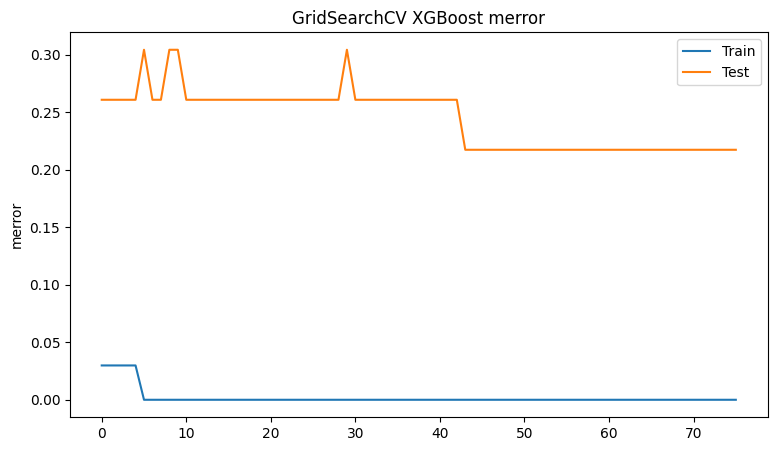


------------------ Confusion Matrix -----------------

[[17  1]
 [ 4  1]]

-------------------- Key Metrics --------------------

Accuracy: 0.78
Balanced Accuracy: 0.57

Micro Precision: 0.78
Micro Recall: 0.78
Micro F1-score: 0.78

Macro Precision: 0.65
Macro Recall: 0.57
Macro F1-score: 0.58

Weighted Precision: 0.74
Weighted Recall: 0.78
Weighted F1-score: 0.74

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.50      0.20      0.29         5

    accuracy                           0.78        23
   macro avg       0.65      0.57      0.58        23
weighted avg       0.74      0.78      0.74        23

---------------------- XGBoost ----------------------


In [18]:
plot_results(xgb_clf, X_red_test, y_red_test)

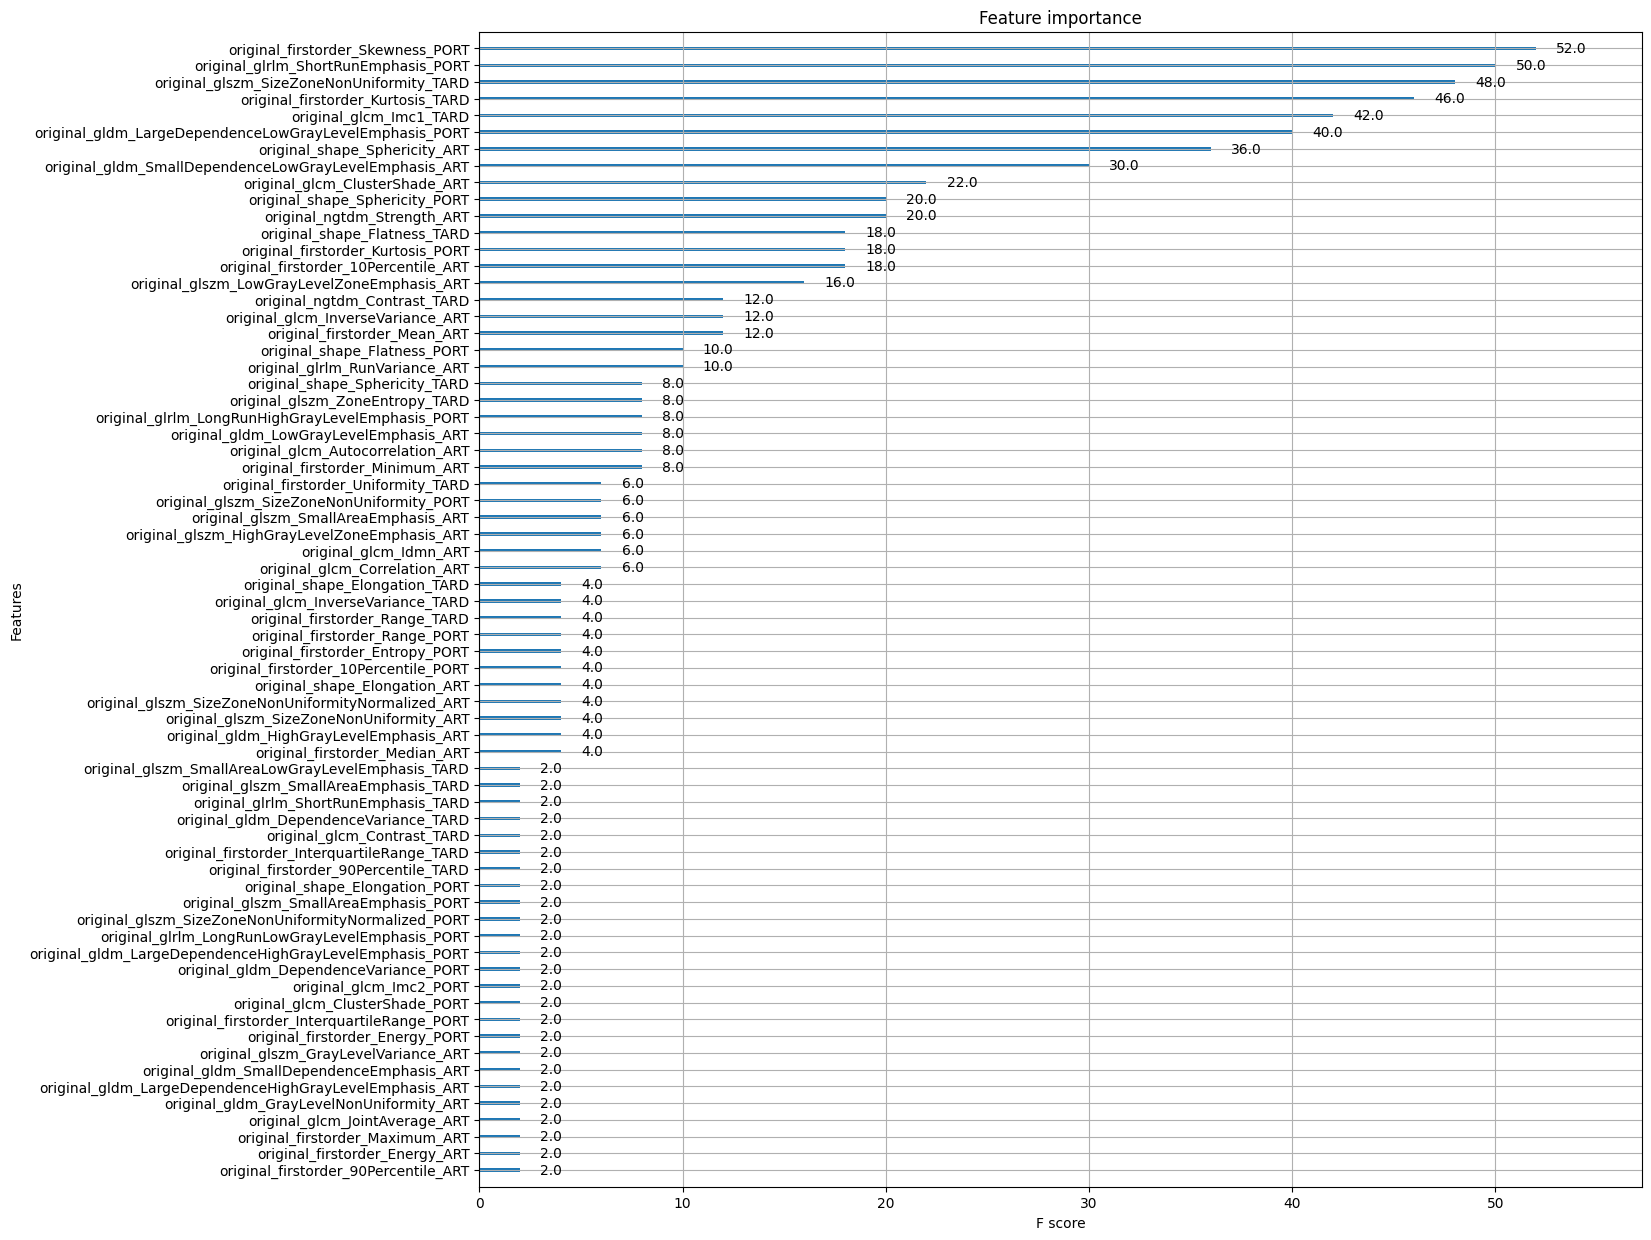

In [19]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_clf, ax=ax)
plt.show()

Ensuite, on inclut les Mixtes

In [23]:
# train and test split --> stratified
X = df_concat.drop('classe_name', axis=1).copy()
y = df_concat['classe_name'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

y_train.replace('CHC', 0, inplace = True)
y_train.replace('CCK', 1, inplace = True)
y_train.replace('Mixtes', 2, inplace = True)

y_test.replace('CHC', 0, inplace = True)
y_test.replace('CCK', 1, inplace = True)
y_test.replace('Mixtes', 2, inplace = True)

In [24]:
xgb_clf2 = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=3,
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.005,
                            max_depth=10,
                            #reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)

xgb_clf2.fit(X_train,
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

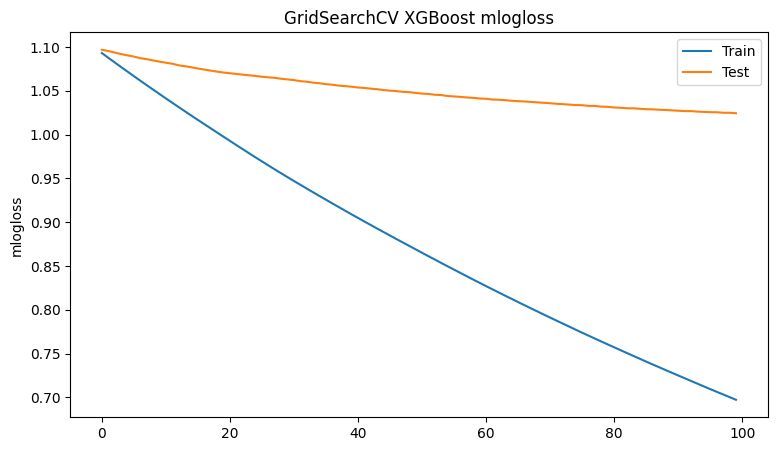

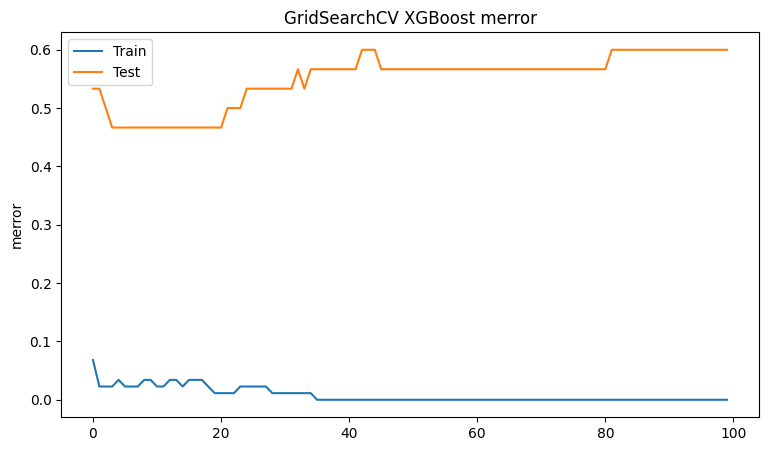


------------------ Confusion Matrix -----------------

[[10  2  6]
 [ 2  1  2]
 [ 5  1  1]]

-------------------- Key Metrics --------------------

Accuracy: 0.40
Balanced Accuracy: 0.30

Micro Precision: 0.40
Micro Recall: 0.40
Micro F1-score: 0.40

Macro Precision: 0.32
Macro Recall: 0.30
Macro F1-score: 0.31

Weighted Precision: 0.42
Weighted Recall: 0.40
Weighted F1-score: 0.41

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.25      0.20      0.22         5
           2       0.11      0.14      0.12         7

    accuracy                           0.40        30
   macro avg       0.32      0.30      0.31        30
weighted avg       0.42      0.40      0.41        30

---------------------- XGBoost ----------------------


In [25]:
plot_results(xgb_clf2, X_test, y_test)